# COGS 108 - Final Project 

# Overview

For our project, we used machine learning regression to more accurately determine the olive moment of comets in Comet Assays. To accomplish this, we collected a large number of data(images) that represent Comet assays. We wrote our own circle detection algorithm to identify the heads of comets. Following that, we created a Neural Network that uses the circle detection algorithm to identify heads and calculate the olive moments. In order to train the neural network, we compiled a set of images with corresponding olive moment calculations that we already had, and used that data to train the neural network. 

# Names

- Mara Casebeer
- Colin Drewes
- Evan Lam
- Alex Lin
- Daniel Walder

# Research Question

Can we emulate or improve on the effectivness of Open Comet for comet detection and mean olive moment extraction?

## Background and Prior Work

Comet Assays are a widely-used biological tool to assess DNA and RNA single-strand damage from UV exposure. Cells with damaged DNA (like from UV radiation) are embedded onto an agarose-coated slide and lysed, essentially dissolving the membranes and giving us access to the DNA. After this, the slides are stained using a fluorescent dye and placed in an electrophoresis machine that separates the strands by weight (4). The result of this assay is an image of stained DNA/RNA that resembles a comet. The “head” is made up of the intact DNA and the “tail” consists of the damaged or broken pieces of single-stranded DNA. The current industry standard is to use an open source ImageJ plug-in called Open Comet, which used an intensity profile analysis (1). While Open Comet is able to quickly recognize comets and calculate the olive moment (DNA % and the distance between the intensity-weighted centroids of head and tail), it often incorrectly identifies the heads and cannot deal with multiple comets lying on top of each other. As a result, scientists have to comb through every cell in their Comet Assay dataset and check Open Comet’s identification. This is time consuming and inefficient.

References (include links):
- 1) Industry standard (http://www.cometbio.org/)
- 2) Identify circles (https://stackoverflow.com/questions/9860667/writing-robust-color-and-size-invariant-circle-detection-with-opencv-based-on)
- 3) Tensor Flow Regression (https://www.tensorflow.org/tutorials/keras/regression)
- 4) Comet Assay
(https://www.sigmaaldrich.com/life-science/cell-biology/cancer-research/learning-center/cancer-research-protocols/comet-assay.html)

# Hypothesis


With a superior method of comet detection than current heuristics, and a machine learning regression approach for analysis, we will be able to more accurately extract the mean olive moment from any given sample. Leveraging the significant preexisting circle detection methods in python, we believe we can better screen our data set compared to the current industry standard (Open Comet). Using a novel machine learning regression approach (Tensorflow) to extract the olive moment from comets, we will replicate the usefulness of Open Comet.

# Dataset(s)

- Dataset Name: Comet Assay Slides
- Link to the dataset: https://github.com/COGS108/group001_wi20/tree/master/data/orig
- Number of observations: 40 images, 933 comets identified by Open Comet
- Description: This dataset comprises of images from four different comet assay slides where each slide is a different experimental group. Each of the 10 pictures of each experiment contains a different number of comets. Overall there were 933 "comets" identified by Open Comet.



- Dataset Name: splits
- Link to the dataset: https://github.com/COGS108/group001_wi20/tree/master/data/splits
- Number of observations: 478
- Description: This data set contains the same comets as above, but each comet is didivded into their own individual image through a programatic approach. Each file contains an individual comet rather than a collection of comets. 

The "Comet Assay Slides" dataset is our original set of data. Our circle detection algorithm splits the "Comet Assay Slides" data into the splits data so we can use a neural network to better calculate the olive moments of the comets by looking at the comets individually.

# Setup
Tools for graphical analysis and Tensorflow nural network

In [1]:
#!pip install --user tensorflow==1.14.0

import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from numpy import asarray
from numpy import uint8
import seaborn as sns
import random
import xlrd

# Data Cleaning

The first step of data cleaning is performed by the scientists who are working with the comet assay dataset. The scientists go through the excel file that is outputted by Open Comet and marks the cells that are misidentified. One of our team members is trained in this method, and did the first data cleaning step. There are several ways that Open Comet misidentifies cells.

(1) Identifying two comets as one: When two comets are close together, Open Comet can have a difficult time separating them. This is one of the most common errors made by Open Comet.
<img src="files/docs/maraImages/mara1.png">

(2) Misidentifies head: Open Comet identifies the head of the comet and uses this to calculate the Olive Moment. However, it sometimes incorrectly identifies the head.
<img src="files/docs/maraImages/mara2.png">

(3) Over Identifies Comets: Open Comet often selects background specs or noise as comets.
<img src="files/docs/maraImages/mara3.png">

(4) Bacterial Cells: Bacteria have a very different shape in comet assays than the C3H cells we are using. Bacterial cells can be identified by a small head and a wide, fan-shaped tail.
<img src="files/docs/maraImages/mara4.png">

### Enacting Image Parser
In order to train our tensorflow image regression, we need to extract individual comets from the input comet assay images. This is a complicated process as it involves searching an image for circles, while avoiding false positives. This was writen as a standalone python3.7 program, and the source code is avalible in src/ImageParse.py. This can be enacted by calling the src/Main.py program which just parses command line inputs. It takes as arguments an input file and an output file. The input file contains the unadulterated comet samples, and the output file contains the outputed "splits," which are the enclosures of the individual comets. In order to process all the images in data/orig/phase1 into "splits in data/splits/phase1," we call:

!python3.7 src/Main.py data/orig/phase1 data/splits/phase1

This takes a set of input images which look like this:
<img src="files/docs/pipeline/orig.jpg">

And our program outputs the individual comets for each of the input images!

<img src="files/docs/pipeline/indiv.png">

## Image Processing
Luckily python has a number of helpful packages to deal with image manipulation. We leverage opencv to perform the majority of these operations. Below is the main functionality of this process. This takes as an input a file name to open:

In [1]:
#--------------------------------------------------------------------------#
# getSplit
# This extracts the circles from the original image. This leverages and
# opencv method called Houghs Circles, which seems to be the best wawy to
# identify circles in an image. It returns a list of the circles detected
# @param inImage     - The input image name which is to be processed 
# @return circs, img - The array of circles detected and the img read 
#--------------------------------------------------------------------------#
def getSplit(inImage):
    # Open the original image based on the input file name
    img = cv2.imread(inImage)
    # Convert the image to grayscale as that is what houghs requires
    gs = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # This uses a Gaussian transform to smooth out singularities
    # The (15,15) region to apply filter at each pix, needs to be refined. 
    gs = cv2.GaussianBlur(gs, BLUR, 0)

    # 4.9 is some ratio of resolution, may need to be refined
    # 50 is the min dist between circles, it is disadvantagous to have this
    # high as we want to detect those circles so we can throw out the bad
    # data 
    # 30 is some screening factor which will through out some bad circs
    circs = cv2.HoughCircles(gs, cv2.HOUGH_GRADIENT, HOUGHS, 50, 100, 30,
                                              minRadius=40, maxRadius=60)

    return circs, img

After reading the image, we apply a greyscale as we dont want any color when we are detecting circles. This is done through the following function:

gs = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

Which gives the following image output.
<img src="files/docs/pipeline/B2G.png">

This is now much easier for our circle recognizer to process, but we can do more. A gaussian blur is an image processing function which applys a 2D filter to produce surfaces of smooth contours. It does this by taking a weighted average of each pixel with surrounding pixels. This helps to smooth out any irregularities of the comets as well as remove the small "speckles" you can still see in the image above which we do not want to detect. It also serves to reduce the size of our input images by nearly 2-fold, which is helpful for the circle detection process. We use the following opencv function call to perform this, where BLUR is defined in the source file to be a (15,15) region:

gs = cv2.GaussianBlur(gs, BLUR, 0)

This results in the following output image:
<img src="files/docs/pipeline/GB.png">

While difficult to detect visually, this significantly improves the performance of our circle detection. We are finally ready to actually gather the comets of our image. This uses an opencv function called Houghs circles, which takes an input image, a number of parameters, and returns the coordinates of the circles. We capture this with the followig function call:

In [ ]:
circs = cv2.HoughCircles(gs, cv2.HOUGH_GRADIENT, HOUGHS, 50, 100, 30,
                                              minRadius=40, maxRadius=60)

We can then add a bounding circle to each comet (code avalible in src/ImageParse.py). We get the image below as a result. While all the comets are detected in the image (including the ones not encircled), we apply a screening process to throw out what we see as bad values. Comets too close together are discarded, as their tails will intersect. Comets which go off either edge of the screen are discarded. We place specification on the maximum and minimum size of the commet, so we do not detect some supercircle of the image or some "speckle" we do not want to register. This process is not erorr-proof, but still does significantly better then the openComet alternative. A more detailed comparison is done in the Data Analysis and Results section.
<img src="files/docs/pipeline/key.png">

After each circle is found we take a 190 by 70 pixel region to capture each comet. These are all written to the provided output file at the start of the program. Now, we have collected individual comets from any given file of input images. This is just the general process of how the image processing portion is performed, and there is far more nuance in the overall process which can be seen in "src/ImageParse.py".

# Data Analysis & Results

## Comet Detection

As a first step of our analysis it is important to understand where Open Comet is misidentifying comets. This data set was gathered manually (if a program could do this then it would already answer our research question), and assembled in the correctness.csv file. This contains a set of 3-tuples of bits. A 0 or 1 in the first column means our new circle detection approach identified or did not identify a particular comet, a 0 or 1 in the second column means Open Comet identified or did not identify a comet. Finally, a 0 or 1 in the final column is the "true" solution as identified by our trained experts. The comets that this data was collected for was a random sample of ~200 comets from our dataset. This only looks at comets that either or both of the programs detected (there would be little point in comparing comets both did not detect). We can perform a more fine grained analysis with this data below. The correct section of the chart refers to when the respective method's result matched with the solution. Under detection refers to when one of the programs failed to detect a comet which should have been detected. Over detection is where one of the programs extraneously detects a comet that should not have been detected. The summary of the results is below:

            Correct  Under Detected  Over Detected
New             199               4              6
Open Comet      142              45             22


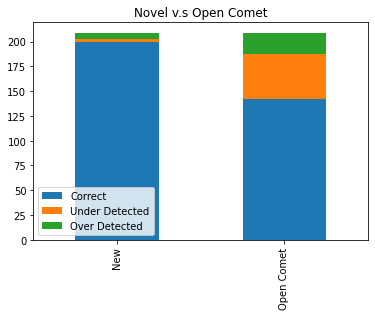

In [10]:
import pandas as pd
df = pd.read_csv('data/correctness.csv')
df.columns
newAC = df.loc[df[' True']==df['New']]
newOD = df.loc[df[' True']==0].loc[df['New']==1]
newUD = df.loc[df[' True']==1].loc[df['New']==0]
openAC = df.loc[df[' True']==df[' openComet']]
openOD = df.loc[df[' True']==0].loc[df[' openComet']==1]
openUD = df.loc[df[' True']==1].loc[df[' openComet']==0]

dfstacked1=[[newAC.shape[0], newOD.shape[0],newUD.shape[0]],[openAC.shape[0],openOD.shape[0],openUD.shape[0]]]

dfstacked=pd.DataFrame(dfstacked1,index=['New','Open Comet'], columns=['Correct','Under Detected', 'Over Detected'])

dfstacked.plot.bar(stacked=True).set_title("Novel v.s Open Comet")

print(dfstacked)

From our analysis of 209 comets, we had a marked improvement over Open Comet for accuractely detecting comets. Open Comet made in error 32%(!!!) of its detections. We are able to show that the majority of these (67%) were over detections. In comparison our novel approach only failed on (4.7%) of the comets, with a relatively even balance between each type of failure. While this is just the first step of any comet analysis program, we have the potential to remove the need for researches to manually comb over data to remove the mistakes of Open Comet.

## Comet Regression

Since the data to be analyzed is a list of images, we decided to use a regressional neural network to predict the Olive Moment of each image. Furthermore, we decided to use Keras from Google's Tensorflow because of its beginner-friendliness as well as it being a frontier in the machine learning society. The following section shows how we set up Tensorflow and contrasts different constellations of the neural network in an afford to minimize the loss function.

In order to give our keras.model the images and corresponding olive moments as an input, we first have to create 2 lists, one containing the images stored as a grayscale numpy array, the other containing the corresponding olive moments. It is essential that the index of any image corresponds to the index of its olive moment in the other list. This is achieved by creating a dataframe out of an excel sheet containing the image number-olive moment associations, then assembling the actual image file name and finally chronologically loading the images in the established order into a list.

In [2]:
#converts the data given by the excel sheet into the corresponding file name of the actual image
def convertImageName(splitNumber, fileNumber):
    fileNumber = str(int(fileNumber))
    splitNumber = str(int(splitNumber))
    image_Name = fileNumber[:1] + ' ' + fileNumber[1:] + ' [Published].jpg_split_' + splitNumber[:3] + '.tif'
    return image_Name

#creates a df from the excel sheet and applies the above function 
#to create a new column storing the corresponding image file names
df = pd.read_excel('OliveMoments.xlsx')
df['image_Names'] = df.apply(lambda x: convertImageName(x.label, x.fileNumber), axis=1)
images = list()
imageNames = df['image_Names'].values

#the corresponding olive moments
oliveMoments = asarray(df['oliveMoment'].values)

#loads the images corresponding to the olive moments as a grayscale numpy array into a list
#we also divide each pixel by 255.0, since according to documentation it is easier for tensorflow to work in a range from 0-1
for image_Name in imageNames:
    images.append(asarray(Image.open('data_final/' + image_Name).convert('L')) / 255.0)
images = asarray(images)

Next we need to shuffle and split our 2 lists into training and test data. As it is convention in machine learning, we decided on a 80/20 split.

In [7]:
#shuffle data
combined = list(zip(images, oliveMoments))
random.shuffle(combined)
images[:], oliveMoments[:] = zip(*combined)

#split data 80:20
training_num = int(len(images) * 0.8)
training_images = images[:training_num]
training_labels = oliveMoments[:training_num]
test_images = images[training_num:]
test_labels = oliveMoments[training_num:]

Let's do some simple checks to see if the test data is a good representation of our data.

In [8]:
dfAll = pd.DataFrame()
dfAll['all_moments'] = oliveMoments
dfTest = pd.DataFrame()
dfTest['test_moments'] = test_labels
print(dfAll.describe())
print()
print(dfTest.describe())

       all_moments
count   352.000000
mean      8.623583
std      13.610606
min       0.021858
25%       1.117998
50%       2.434515
75%      10.518075
max      86.137427

       test_moments
count     71.000000
mean       8.501118
std       12.676589
min        0.101078
25%        1.022737
50%        2.300530
75%       14.419280
max       61.162042


Looks good. Now it is time to analyze different keras.model constellations to minimize our loss function. First, consider this first simple model consisting of a (flattened) input layer, one hidden layer of 128 neurons and one output neuron representing the predicted olive moment. As for the model.compile parameters, we choose optimizer='adam' since according to the Tensorflow "this method is 'computationally efficient, has little memory requirement, invariant to diagonal rescaling of gradients, and is well suited for problems that are large in terms of data/parameters'" (https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/Adam). Furthermore, we choose 'mean_absolut_error' as our loss function because we want to get a sense of the networks improvement. However, to actually test our network's functionality, we will calculate the mean of our predictions later. Let's see for how many epochs we can train the network before having a neglectable improvement in the loss function.

In [9]:
model1 = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, 
    activation=tf.nn.relu),
    tf.keras.layers.Dense(1)])
model1.compile(optimizer='adam', loss='mae')
history = model1.fit(training_images, training_labels, epochs=100, verbose=0)

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


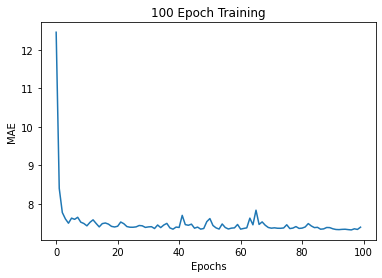

In [15]:
hist1 = pd.DataFrame(history.history)
hist1['epoch'] = history.epoch
ax = hist1['loss'].plot.line(x='epochs', y='MAE', title = "100 Epoch Training")
ax.set_xlabel("Epochs")
ax.set_ylabel("MAE");

The graph shows the MAE loss of the network after each epoch. We can see the most progress is done in the first 10 epochs (from 12.5 to 7.5), and then the network goes just below 6 MAE after epoch 100. Since we are working with limited resources, let's therefore train our different configurations on 10 epochs each. First, let's train this network again but this time only on 10 epochs.

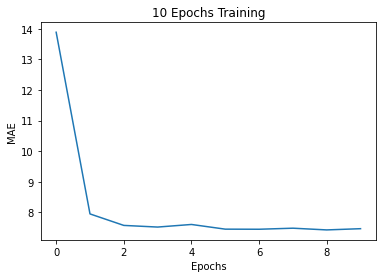

In [17]:
model1 = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation=tf.nn.relu),
    tf.keras.layers.Dense(1)])
model1.compile(optimizer='adam', loss='mae')
history = model1.fit(training_images, training_labels, epochs=10, verbose=0)
hist1 = pd.DataFrame(history.history)
hist1['epoch'] = history.epoch
ax = hist1['loss'].plot.line(x='epochs', y='MAE', title = "10 Epoch Training")
ax.set_xlabel("Epochs")
ax.set_ylabel("MAE");

And let's see how it performs with our test data.

71/71 [==============================] - 0s 1ms/sample - loss: 7.4849


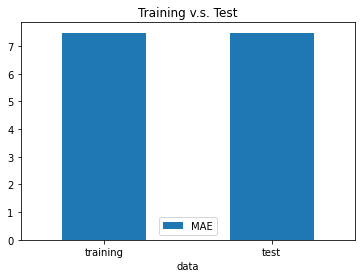

In [18]:
#create boxplot from our training and evaluation losses
test_loss = model1.evaluate(test_images, test_labels)
losses = [hist1['loss'][9], test_loss]
df_compare = pd.DataFrame({'data':['training', 'test'], 'MAE':losses})
ax = df_compare.plot.bar(x='data', y='MAE', rot=0, title = "Training v.s. Test")


It seems like the MAE between our training and test data is about 0 points apart. However, what we really care about is if our network can calculate the correct mean of olive moments of a sample. Let's calculate the mean our network predicts and compare it to the actual mean.

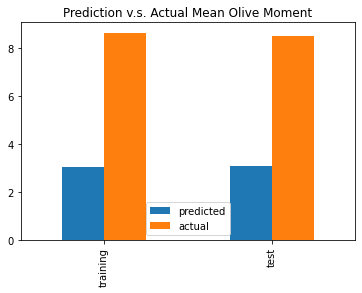

In [20]:
meanTraining = model1.predict(training_images).mean()
trueMeanTraining = training_labels.mean()
meanTest = model1.predict(test_images).mean()
trueMeanTest = test_labels.mean()
actualMeans = [trueMeanTraining, trueMeanTest]
predictedMeans = [meanTraining, meanTest]
index = ['training', 'test']
dfMean = pd.DataFrame({'predicted': predictedMeans, 'actual': actualMeans}, index=index)
dfMean.plot.bar(title = "Prediction v.s. Actual Mean Olive Moment");

Looking at the above results, we can conclude that our network configuration predicts the mean olive moment of our data about 5 points short. Whether this is worse or better compared to open comet, the currently used software in industry, will be discussed later. First, let's see if a convolutional neural network with 1 convolutional layer performs better. 

In [24]:
training_images = training_images.reshape(281, 190, 140, 1)
test_images = test_images.reshape(71, 190, 140, 1)

model2 = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', input_shape=(190, 140, 1)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation=tf.nn.relu),
    tf.keras.layers.Dense(1)])
model2.compile(optimizer='adam', loss='mae')
history = model2.fit(training_images, training_labels, epochs=10)

Epoch 1/10
281/281 [==============================] - 7s 25ms/sample - loss: 18.3159
Epoch 2/10
281/281 [==============================] - 5s 19ms/sample - loss: 10.4321
Epoch 3/10
281/281 [==============================] - 5s 19ms/sample - loss: 7.8929
Epoch 4/10
281/281 [==============================] - 5s 19ms/sample - loss: 7.6041
Epoch 5/10
281/281 [==============================] - 5s 19ms/sample - loss: 7.6929
Epoch 6/10
281/281 [==============================] - 5s 19ms/sample - loss: 7.5009
Epoch 7/10
281/281 [==============================] - 5s 18ms/sample - loss: 7.5148
Epoch 8/10
281/281 [==============================] - 5s 19ms/sample - loss: 7.5310
Epoch 9/10
281/281 [==============================] - 5s 19ms/sample - loss: 7.5254
Epoch 10/10
281/281 [==============================] - 5s 19ms/sample - loss: 7.4310


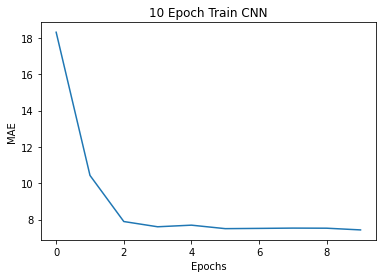

In [25]:
hist2 = pd.DataFrame(history.history)
hist2['epoch'] = history.epoch
ax = hist2['loss'].plot.line(x='epochs', y='MAE', title = "10 Epoch Train CNN")
ax.set_xlabel("Epochs")
ax.set_ylabel("MAE");

Although the CNN works with a bigger range, the loss after 10 epochs is very similiar to our earlier network.

71/71 [==============================] - 0s 6ms/sample - loss: 7.6095


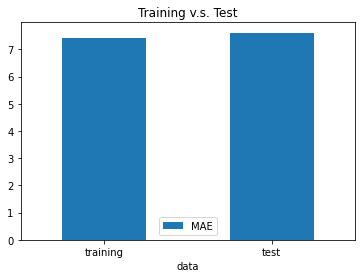

In [26]:
test_loss2 = model2.evaluate(test_images, test_labels)
losses = [hist2['loss'][9], test_loss2]
df_compare = pd.DataFrame({'data':['training', 'test'], 'MAE':losses})
df_compare.plot.bar(x='data', y='MAE', rot=0, title = "Training v.s. Test")

Furthermore, the predicted mean of our CNN also matches with our earlier network, being about 5 points below the actual mean.

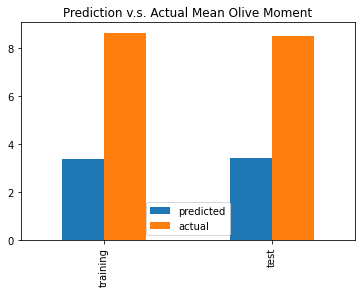

In [28]:
meanTraining = model2.predict(training_images).mean()
trueMeanTraining = training_labels.mean()
meanTest = model2.predict(test_images).mean()
trueMeanTest = test_labels.mean()
actualMeans = [trueMeanTraining, trueMeanTest]
predictedMeans = [meanTraining, meanTest]
index = ['training', 'test']
dfMean = pd.DataFrame({'predicted': predictedMeans, 'actual': actualMeans}, index=index)
dfMean.plot.bar(title = "Prediction v.s. Actual Mean Olive Moment");

We can conclude, that it does not make a big difference which network, out of our 2 tested network constellations, we choose. Both have similar performances and their predicted means are both off by 5 points. Due to time efficiency, we will continue with model1 for our conclusion.

Finally, let's reach a conclusion whether the neural network trained by us is a better solution for industry than Open Comet. First we must define what better even means, since Open Comet and machine learning are quite different approaches to the same problem.
The main problem with Open Comet is that one must manually go through each cell and decide if it was correctly detected. However, ignoring possible human error, once this data is cleaned, we can assume that Open Comet calculated mean is 100 percent correct. On the other hand, our cell detection has a neglectable error rate, but instead our neural network makes an error when calculating the olive moment mean.
Let's compare the mean olive moment by Open Comet of cleaned vs uncleaned data and contrast that to our neural network (we will use model1).

Average Olive Moment for Un-Cleaned Data processed by Open Comet:  16.38
Average Olive Moment for Cleaned Data processed by Open Comet:  8.76
Average Olive Moment for data processed by neural network:  3.059999942779541


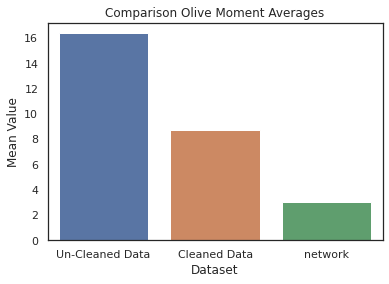

In [29]:
#Calculate the combined average of phase 1 and phase 2 data (we combined phase 1 and phase 2 data for our dataset)
unAvg = ((203 * 14.60562317) + (127 * 19.3457856)) / (204 + 127)
clAvg = ((143 * 6.568894719) + (95 * 12.06652399)) / (143 + 95)
predictAvg = model1.predict(images).mean()

#round numbers
unAvg = round(unAvg, 2)
clAvg = round(clAvg, 2)
predictAvg = round(predictAvg, 2)

#dataframe with average values
df_Avg = pd.DataFrame([['UnCleaned', unAvg], ['Cleaned', clAvg], ['network', predictAvg]], columns = ["dataset_condition", "olive_moment_averages"])

#create barplot
sns.set(style = 'white')
ax = sns.barplot(x = 'dataset_condition', y = 'olive_moment_averages', data = df_Avg, order = ["UnCleaned", "Cleaned", "network"])
#ax = sns.lineplot(x = 'dataset_condition', y = 'olive_moment_averages', data = df_Avg)
#add title and axis labels
ax.set_title('Comparison Olive Moment Averages')
ax.set_ylabel('Mean Value')
ax.set_xlabel('Dataset')
#set tick lables
ax.set_xticklabels(("Un-Cleaned Data", "Cleaned Data", "network"))

print("Average Olive Moment for Un-Cleaned Data processed by Open Comet: ", df_Avg.iloc[0, 1])
print("Average Olive Moment for Cleaned Data processed by Open Comet: ", df_Avg.iloc[1, 1])
print("Average Olive Moment for data processed by neural network: ", df_Avg.iloc[2, 1])

We can see that without manual cleaning, Open Comet is about 8 points off. Our network, which does not require manual cleaning, is about 5 points off. However, once the data is cleaned, Open Comet correctly identifies all olive moments with 0 points error (ignoring possible human error). How much significance human error poses in those calculations and whether our network always is 5 points off no matter the data, goes beyond the scope of this project and leaves room for further improvement. Therefore, it is up to the user whether he wants to use Open Comet and manually clean the results, or instead use our neural network which gives a lower but still significant error. 

# Ethics & Privacy

There is a risk with machine learning that our model will “overfit” the training data, thus making future uses yield inaccurate results. This could lead to incorrect conclusions that future scientists use or base research questions on. There is also potential that the training data we use has inaccuracies. We did our best and continue to screen these inaccuracies out, but biased results may still occur anytime our algorithm is used. 

There is no risk of privacy towards humans, because the current set of cells that is used for this research are mice cells. In the future, if the current research of olive moments applies to humans, the data itself will not have privacy implications either. It is highly improbable that the person that participates in the research will be able to be identified through an image of their cell. 

However, one ethical implication of our project would be if our neural network program does not correctly identify the head of the comet cells and does not calculate and predict olive moments correctly. If this was the case, scientists who use our program will not be able to analyze cell damage accurately. This would result in flawed research, and we would not be able to analyze how certain diseases and products could damage human cells. 

# Conclusion & Discussion

Overall, our project goal was to create a new pipeline that detects comets from comet assays and calculates the olive moment. To be successful, our project should have (1) made less mistakes while detecting comets than Open Comet and (2) correctly calculated the olive moment. Having a system that is able to do both of these would greatly reduce the amount of time scientists using comet assays need to analyze their data. Automating the data cleaning section and comet assay selection  would also decrease the likelihood of human error, therefore increasing the accuracy of the results. 

Although our project has made great strides into correctly identifying comets and calculating olive moments, there is still much work to be done. Our current circle detection algorithm relys on a resolutional coefficent as an argument for the circle detection. While this can be calculated for any arbitary image using a formula, our current design does not. An implementation of this would require a more detailed reading of the original paper. It is also still prone to making some misidentificaitons, though significantly less than Open Comet. 

Regarding the olive moments, there may be a tiny bit of human error that still affects the calculation of our olive moments. In addition, our network, although pretty accurate and consistent on averages, continues to result in an error of four points off of the expected value on average. This could be because we have a set size of the split from the original image. If that size is too small, then we could be cutting off a part of the tail of the comet, artificially reducing the olive moment. To fix this, we would need to adjust the size of the splits. In addition, if we gather more data to train our neural network and continue to see an error of four points, then we can simply add four points to our results and confidently predict the correct olive moment. 

Comet assays are used in the analysis of various diseases and therapies.  These applications include radio and chemotherapy for cancer treatment, diabetes, arthritis, and neurodegenerative diseases such as Alzheimer’s.  Our project attempts and somewhat succeeds at improving the industry standard for analyzing comet assay images.  Our circle detection algorithm proved to be more accurate than OpenComet at detecting comets and the neural network was more accurate than OpenComet if the data sets are not manually cleaned.  Improving the efficiency of comet assay analysis will allow for faster tracking of disease progression, giving healthcare providers and researchers the tools they need to reliably provide and develop life-saving treatments.


# Team Contributions

Mara Casebeer: Background, Data Collection, Data Cleaning, Conclusion, Data Analysis and Results, Contribution

Colin Drewes: Data Cleaning, Data Analysis, Hypothesis, Research Question, Data Analysis and Results, Contribution

Evan Lam: Overview, Data Analysis, Ethics & Privacy, Conclusion & Discussion, Contribution

Alex Lin: Data Cleaning, Data Analysis, Conclusion & Discussion, Contribution

Daniel Walder: Data Analysis & Results (Tensorflow), Data Visualization, Contribution
